In [1]:
import pandas as pd
import os
import pickle

In [2]:
file_path = '../Sup/dataset.csv'
dataset = pd.read_csv(file_path,header=None)

dataset.head()

,0,1,2
0,Â‘Endgame' more than lives up to the hype. Aft...,DIRECTING#PERFORMANCE,Positive
1,The most epic 4th installment of Marvel's The ...,WRITING#PERFORMANCE,Positive
2,I'd give it a 10 if they didn't completely scr...,CAST#PERFORMANCE,Positive
3,"I thought it was a Fantastic Movie. Well done,...",CAST#PERFORMANCE,Positive
4,I recently watched this movie again and found ...,CAST#PERFORMANCE,Positive


In [3]:
data = dataset.loc[:,0]
data.head()

0    Â‘Endgame' more than lives up to the hype. Aft...
1    The most epic 4th installment of Marvel's The ...
2    I'd give it a 10 if they didn't completely scr...
3    I thought it was a Fantastic Movie. Well done,...
4    I recently watched this movie again and found ...
Name: 0, dtype: object

In [4]:
label_cat = dataset.loc[:,1]
label_pol = dataset.loc[:,2]
#label_cat.unique()

In [5]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [6]:
data = data.str.lower()
aspect_terms = []
for review in nlp.pipe(data):
    chunks = [chunk.root.text for chunk in review.noun_chunks if chunk.root.pos_ == 'NOUN']
    aspect_terms.append(' '.join(chunks))
dataset[3] = aspect_terms

In [7]:
dataset.head()

,0,1,2,3
0,Â‘Endgame' more than lives up to the hype. Aft...,DIRECTING#PERFORMANCE,Positive,hype years brothers conclusion saga sorrow joy...
1,The most epic 4th installment of Marvel's The ...,WRITING#PERFORMANCE,Positive,installment memory
2,I'd give it a 10 if they didn't completely scr...,CAST#PERFORMANCE,Positive,hulk
3,"I thought it was a Fantastic Movie. Well done,...",CAST#PERFORMANCE,Positive,movie saga mcu stars ending snap thanos retire...
4,I recently watched this movie again and found ...,CAST#PERFORMANCE,Positive,movie acting end story


In [8]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(512, input_shape=(6000,), activation='relu'))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Using TensorFlow backend.


In [9]:
from keras.preprocessing.text import Tokenizer

vocab_size = 6000 # We set a maximum size for the vocabulary
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data)
aspect_tokenized = pd.DataFrame(tokenizer.texts_to_matrix(dataset[3]))

In [10]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

label_encoder = LabelEncoder()
integer_category = label_encoder.fit_transform(label_cat)
dummy_category = to_categorical(integer_category)

In [15]:
history = model.fit(aspect_tokenized, dummy_category, epochs=20, verbose=1)

Epoch 1/20
502/502 [==============================] - 0s 290us/step - loss: 0.0895 - accuracy: 0.9781
Epoch 2/20
502/502 [==============================] - 0s 281us/step - loss: 0.0821 - accuracy: 0.9821
Epoch 3/20
502/502 [==============================] - 0s 274us/step - loss: 0.0737 - accuracy: 0.9821

In [11]:
import matplotlib.pylab as plt

def plot_var(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc , label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title('Training and validation accuracy')

    plt.figure()

    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

0 501
4 497
Train on 501 samples, validate on 493 samples
Epoch 1/5
501/501 [==============================] - 0s 411us/step - loss: 0.0414 - accuracy: 0.9780 - val_loss: 0.0379 - val_accuracy: 0.9817
Epoch 2/5
501/501 [==============================] - 0s 398us/step - loss: 0.0399 - accuracy: 0.9780 - val_loss: 0.0371 - val_accuracy: 0.9817
Epoch 3/5
501/501 [==============================] - 0s 390us/step - loss: 0.0405 - accuracy: 0.9780 - val_loss: 0.0375 - val_accuracy: 0.9817

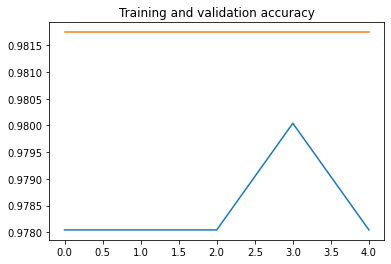

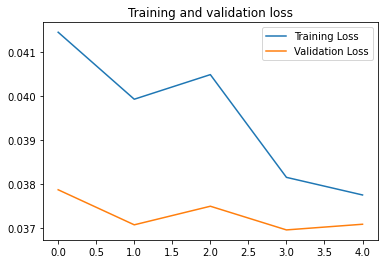

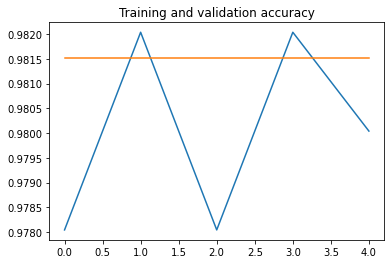

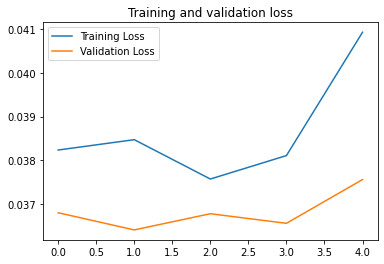

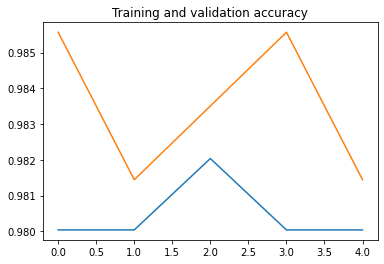

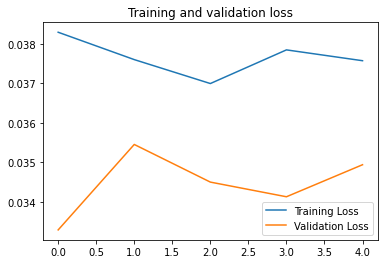

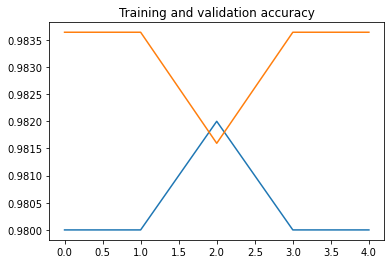

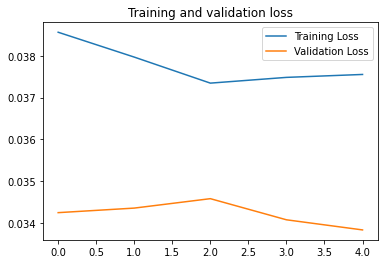

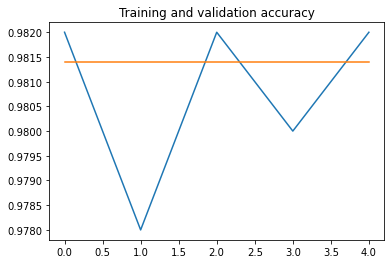

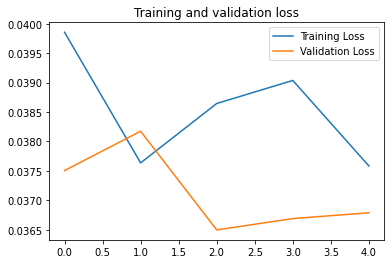

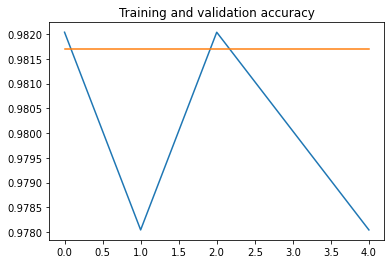

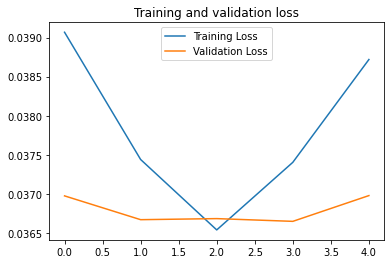

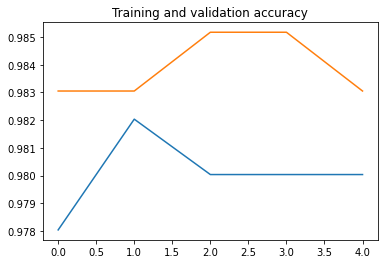

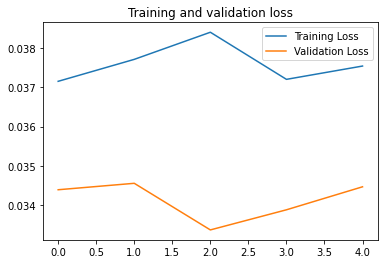

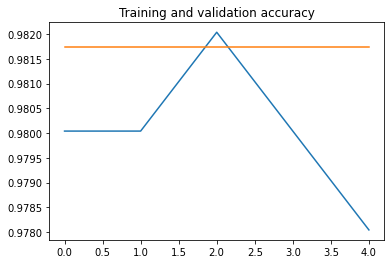

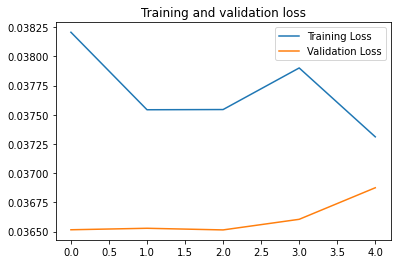

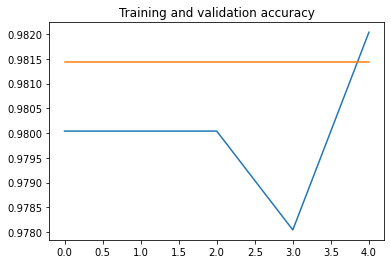

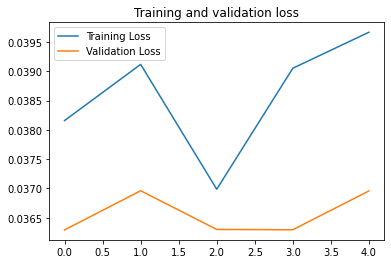

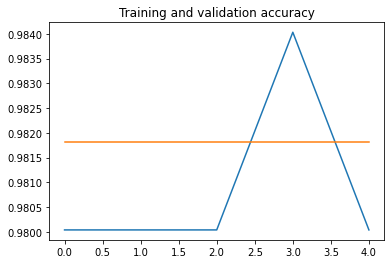

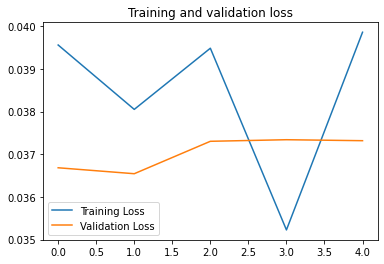

In [13]:
from sklearn.model_selection import KFold

cv = KFold(10,shuffle=True,random_state=1)
for train_ind,test_ind in cv.split(aspect_tokenized):
    print(train_ind[0],train_ind[-1])
    print(test_ind[0],test_ind[-1])
    train_start,train_end,test_start,test_end = train_ind[0],train_ind[-1],test_ind[0],test_ind[-1]
    X_train, X_test, y_train, y_test = aspect_tokenized.loc[train_start:train_end-1,:],\
                                       aspect_tokenized.loc[test_start:test_end-1,:], \
                                       dummy_category[train_start:train_end,:], \
                                       dummy_category[test_start:test_end,:]
    history = model.fit(X_train,y_train,epochs=5,verbose=1,validation_data=(X_test,y_test))
    plot_var(history)

model saving

In [14]:
model_save_path = '../Sup'
weight_save_path = '../Sup'
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)
if not os.path.exists(weight_save_path):
    os.mkdir(weight_save_path)
model.save( '../Sup/categorical_model.h5')
model.save_weights( "../Sup/categorical_model_weights.h5")

In [15]:
# saving
#if not os.path.exists('../Sup/tokenizer.pickle'):
#    os.mkdir('../Sup/tokenizer.pickle')
with open('../Sup/categorical_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
with open('../Sup/categorical_labeleEncorder.pkl', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)